In [2]:
import os,sys
import cPickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from time import time

sys.path.insert(0,'lib/')
import config
import diagnostics
import base_model

from sklearn.metrics import average_precision_score

import tensorflow as tf

%matplotlib inline

In [3]:
with open(config.labels_path) as f:
    labels = pickle.load(f)

In [4]:
def create_filters(d,k):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((1,d,1,k), dtype=np.float32)
    wcos = np.empty((1,d,1,k), dtype=np.float32)
    start_freq = 50.
    end_freq = 6000.
    num_cycles = start_freq*d/44100.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[0,:,0,ind] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[0,:,0,ind] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
            
    return wsin,wcos

class Spectrograms(base_model.Model):
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512                # lvl1 nodes
        self.d = 4096               # lvl1 receptive field
        
        d2_x = 1          # lvl2 input dims_x
        d2_y = 128          # lvl2 input dims_y
        k2 = 128        # num lvl2 filters
        stride_y = 2    # lvl2 stride
        
        d3_x = 25 # lvl3 input dims_x
        d3_y = 1 # lvl3 input dims_y (fully connected)
        k3 = 4096 # num lvl3 filters

        num_regions  = 1 + (self.window-self.d)/self.stride
        #print 'First layer regions: ({},{})'.format(num_regions,self.k)
        num_regions2_x  = 1 + (num_regions-d2_x)/1
        num_regions2_y = 1 + (self.k-d2_y)/stride_y
        #print 'Second layer regions: ({},{})'.format(num_regions2_x,num_regions2_y)
        num_regions3_x = 1 + (num_regions2_x - d3_x)/1
        num_regions3_y = 1 + (num_regions2_y - d3_y)/1

        wsin,wcos = create_filters(self.d,self.k)

        print '---- Weights ----'
        wscale = .0001
        with tf.variable_scope('parameters'):
            w = tf.Variable(wscale*tf.random_normal([d2_x,d2_y,1,k2],seed=999))
            print 'w',w
            wavg = self.register_weights(w,'w',average=.9998)
            w2 = tf.Variable(wscale*tf.random_normal([d3_x,d3_y,k2,k3],seed=999))
            print 'w2',w2
            w2avg = self.register_weights(w2,'w2',average=.9998)
            beta = tf.Variable(wscale*tf.random_normal([num_regions3_x*num_regions3_y*k3,self.m],seed=999))
            print 'beta',beta
            betaavg = self.register_weights(beta,'beta',average=.9998)

        print '---- Layers ----'
        with tf.variable_scope('queued_model'):
            zx = tf.square(tf.nn.conv2d(self.xq,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
               + tf.square(tf.nn.conv2d(self.xq,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            print 'zx',zx
            z2 = tf.nn.relu(tf.nn.conv2d(tf.log(zx+10e-15),w,strides=[1,1,1,stride_y],padding='VALID',data_format='NCHW'))
            print 'z2',z2
            z3 = tf.nn.relu(tf.nn.conv2d(z2,w2,strides=[1,1,1,1],padding='VALID',data_format='NCHW'))
            print 'z3',z3
            y = tf.matmul(tf.reshape(z3,[self.batch_size,num_regions3_x*num_regions3_y*k3]),beta)
            print 'y',y
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.variable_scope('direct_model'):
            self.zx = tf.square(tf.nn.conv2d(self.xd,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
                    + tf.square(tf.nn.conv2d(self.xd,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            self.z2 = tf.nn.relu(tf.nn.conv2d(tf.log(self.zx+10e-15),wavg,strides=[1,1,1,stride_y],padding='VALID',data_format='NCHW'))
            self.z3 = tf.nn.relu(tf.nn.conv2d(self.z2,w2avg,strides=[1,1,1,1],padding='VALID',data_format='NCHW'))
            self.y_direct = tf.matmul(tf.reshape(self.z3,[tf.shape(self.xd)[0],num_regions3_x*num_regions3_y*k3]),betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [5]:
try: model.stop()
except NameError: pass
model = Spectrograms(labels,checkpoint_path='convnet_experimental2_morelvl3/', outputs=1, window=16384, mmap=True,
                     normalize=True, extended_test_set=True, use_mirex=True, init=False, pitch_transforms=5, jitter=.1,
                     restrict=False)

---- Weights ----
w <tf.Variable 'parameters/Variable:0' shape=(1, 128, 1, 128) dtype=float32_ref>
w2 <tf.Variable 'parameters/Variable_2:0' shape=(25, 1, 128, 4096) dtype=float32_ref>
beta <tf.Variable 'parameters/Variable_4:0' shape=(790528, 128) dtype=float32_ref>
---- Layers ----
zx Tensor("queued_model/add:0", shape=(150, 1, 25, 512), dtype=float32)
z2 Tensor("queued_model/Relu:0", shape=(150, 128, 25, 193), dtype=float32)
z3 Tensor("queued_model/Relu_1:0", shape=(150, 4096, 1, 193), dtype=float32)
y Tensor("queued_model/MatMul:0", shape=(150, 128), dtype=float32)


In [21]:
lr = .00001/3/3
mom = .95

# stop the model if it is already running
model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print model.status_header()
    while True:
        if model.iter % 1000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print model.status()
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    print 'Graceful Exit'

avp_test	avp_train	mse_test	mse_train	time	utime
0.787188        0.822874        0.475221        0.535489        201     201     
0.787208        0.823182        0.475425        0.534982        649     200     
0.787281        0.823480        0.475593        0.534573        649     200     
0.787384        0.823754        0.475776        0.534175        649     200     
0.787435        0.824063        0.475903        0.533799        650     201     
0.787426        0.824299        0.476040        0.533439        650     201     
0.787421        0.824572        0.476106        0.533070        650     201     
0.787506        0.824855        0.476152        0.532736        650     201     
0.787626        0.825037        0.476146        0.532465        649     201     
0.787711        0.825271        0.476123        0.532179        648     200     
0.787889        0.825486        0.476045        0.531894        649     200     
0.788003        0.825657        0.475998        0.531648    

0.788090216473
0.474247319284


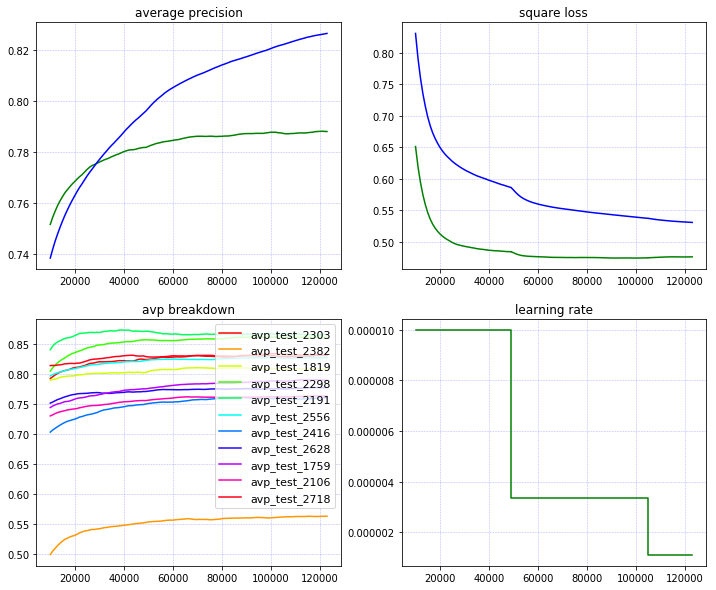

In [6]:
burnin=10
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_test'][2][burnin:],color='g')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_train'][2][burnin:],color='b')
ax2.set_title('square loss')
ax2.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_test'][2][burnin:],color='g')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_train'][2][burnin:],color='b')
ax3.set_title('avp breakdown')
ax3.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
cmap = plt.cm.get_cmap('hsv',len(model.test_ids))
plots = []
keys = []
for i,rec_id in enumerate(model.test_ids):
    plot, = ax3.plot(model.stats['iter'][2][burnin:], model.stats['avp_test_' + str(rec_id)][2][burnin:], color=cmap(i))
    plots.append(plot)
    keys.append('avp_test_' + str(rec_id))
leg = ax3.legend(plots,keys,loc='upper right',ncol=1,prop={'size':11})
ax4.set_title('learning rate')
ax4.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax4.plot(model.stats['iter'][2][burnin:],model.stats['lr'][2][burnin:],color='g')

print max(model.stats['avp_test'][2])
print min(model.stats['mse_test'][2])

# Mirex stats

In [6]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.773352751467


In [7]:
Accavg = Etotavg = 0
for i in range(3):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/3.,Etotavg/3.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
83.15	78.19	81.75	0.67	0.33	0.08	0.10	0.15
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
56.33	60.32	52.71	0.39	0.68	0.14	0.34	0.21
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
80.86	76.84	73.37	0.60	0.41	0.08	0.19	0.14
0.552600558572 0.473992341199


# Extended test set stats

In [8]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids_ext, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.798667349757


In [9]:
Accavg = Etotavg = 0
for i in range(10):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/10.,Etotavg/10.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
83.15	78.19	81.75	0.67	0.33	0.08	0.10	0.15
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
56.33	60.32	52.71	0.39	0.68	0.14	0.34	0.21
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
80.86	76.84	73.37	0.60	0.41	0.08	0.19	0.14
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
86.09	75.81	82.79	0.65	0.32	0.11	0.06	0.15
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
86.53	74.14	88.02	0.67	0.33	0.10	0.02	0.21
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
82.69	76.94	81.08	0.65	0.35	0.09	0.10	0.16
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
76.05	64.73	81.63	0.57	0.57	0.06	0.12	0.38
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
77.71	70.63	78.52	0.59	0.44	0.10	0.12	0.23
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
78.98	72.30	80.92	0.62	0.40	0.10	0.09	0.21
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
76.30	75.76	70.52	0.58	0.40	0.12	0.18	0.11
0.598842562939 0.423021639721
